# **Image Classification: Sparse Transfer Learning with the Python API**

In this example, you will fine-tune a 95% pruned-quantized ResNet-50 model onto the Imagenette dataset using SparseML's Torchvision Integration.

### **Sparse Transfer Learning Overview**

Sparse Transfer Learning is very similiar to typical fine-tuning you are used to when training models. However, with Sparse Transfer Learning, we start the training process from a pre-sparsified checkpoint and maintain the sparsity structure while the fine tuning occurs. 

At the end, you will have a sparse model trained on your dataset, ready to be deployed with DeepSparse for GPU-class performance on CPUs!

### **Pre-Sparsified Image Classification Model**
SparseZoo, Neural Magic's open source repository of pre-sparsified models, contains several families of image classification models including ResNet, MobileNet, and EfficientNet.

In this case, we start the training process from a 95% pruned-quantized [ResNet-50 model](https://sparsezoo.neuralmagic.com/models/cv%2Fclassification%2Fresnet_v1-50%2Fpytorch%2Fsparseml%2Fimagenet%2Fpruned95_quant-none), which is identified by the following SparseZoo stub:

```bash
zoo:cv/classification/resnet_v1-50/pytorch/sparseml/imagenet/pruned95_quant-none
```


**Let's dive in!**

## **Installation**

Install SparseML via `pip`.



In [ ]:
!pip install sparseml[torch,torchvision]

If you are running on Google Colab, restart the runtime after this step.

## **Code Level APIs**

If you need to integrate further into a system, you can use the code API directly.

In [ ]:
import sparseml
import sparsezoo
import torch
import torchvision
print(torch.__version__)

## **Step 1: Download the Sparse Checkpoint from the SparseZoo**

We can use a SparseZoo stub to identify the model we want to use. In this case, we will use the 95% pruned and quantized version, which retains 99% of the baseline accuracy of the dense model. 

[Checkout the model card on SparseZoo](https://sparsezoo.neuralmagic.com/models/cv%2Fclassification%2Fresnet_v1-50%2Fpytorch%2Fsparseml%2Fimagenet%2Fpruned95_quant-none)

In [ ]:
from sparseml.pytorch.models import ModelRegistry

ZOO_STUB = "zoo:cv/classification/resnet_v1-50/pytorch/sparseml/imagenet/pruned95_quant-none?recipe_type=transfer-classification"

# SparseZoo stub to pre-trained sparse-quantized ResNet-50 for imagenet dataset
model = ModelRegistry.create(
    key="resnet50",
    pretrained_path=ZOO_STUB,
    pretrained_dataset="imagenette",
    num_classes=10,
    ignore_error_tensors=["classifier.fc.weight", "classifier.fc.bias"],
)
input_shape = ModelRegistry.input_shape("resnet50")
input_size = input_shape[-1]

## **Step 2: Setup The Dataset**

Download the datasets. We will use Imagenette dataset for this example. Checkout the [PyTorch documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) on Datasets and Dataloaders for more derails on how Datasets work.

In [ ]:
from sparseml.pytorch.datasets import ImagenetteDataset, ImagenetteSize

# Define your train and validation datasets below, here we will use Imagenette
print("\nloading train dataset...")
train_dataset = ImagenetteDataset(
    train=True, dataset_size=ImagenetteSize.s320, image_size=input_size
)

print("\nloading val dataset...")
val_dataset = ImagenetteDataset(
    train=False, dataset_size=ImagenetteSize.s320, image_size=input_size
)

## **Step 3: Setup Training Loop and Objects**

This training loop is all native PyTorch, there is nothing SparseML related.

In [ ]:
from tqdm.auto import tqdm
import math

def run_model_one_epoch(model, data_loader, criterion, device, train=False, optimizer=None):
    if train:
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    total_correct = 0
    total_predictions = 0

    # loop through batches
    for step, (inputs, labels) in tqdm(enumerate(data_loader), total=len(data_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        if train:
            optimizer.zero_grad()

        # compute loss, run backpropogation
        outputs, _ = model(inputs)  # model returns logits and softmax as a tuple
        loss = criterion(outputs, labels)
        if train:
            loss.backward()
            optimizer.step()

        running_loss += loss.item()

        # run evaluation
        predictions = outputs.argmax(dim=1)
        total_correct += torch.sum(predictions == labels).item()
        total_predictions += inputs.size(0)

    # return loss and evaluation metric
    loss = running_loss / (step + 1.0)
    accuracy = total_correct / total_predictions
    return loss, accuracy

Setup the dataloaders, loss, and optimizer. These are all native PyTorch, there is nothing SparseML related.

In [ ]:
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

# hyperparameters
BATCH_SIZE = 32

# setup device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Using device: {device}")

# setup data loaders
train_loader = DataLoader(
    train_dataset, BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=8
)
val_loader = DataLoader(
    val_dataset, BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=8
)

# setup loss function and optimizer, LR will be overriden by sparseml
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=8e-3)

## **Step 5: Add Sparse Transfer Learning Logic with SparseML**

First, we will download the use the SparseZoo `Model` class to download the transfer learning recipe to the local directory. You can also download directly from the SparseZoo website.

In [ ]:
from sparsezoo import Model

download_directory = "./model_download_directory"
zoo_model = Model(ZOO_STUB, download_path = download_directory)
recipe_path = zoo_model.recipes.default.path
print(recipe_path)

#### Inspecting the Recipe

Here is the transfer learning recipe:

```yaml
# Epoch and Learning-Rate variables
num_epochs: 10.0
init_lr: 0.0005

# quantization variables
quantization_epochs: 6.0

training_modifiers:
  - !EpochRangeModifier
    start_epoch: 0.0
    end_epoch: eval(num_epochs)

  - !LearningRateFunctionModifier
    final_lr: 0.0
    init_lr: eval(init_lr)
    lr_func: cosine
    start_epoch: 0.0
    end_epoch: eval(num_epochs)

# Phase 1 Sparse Transfer Learning / Recovery
sparse_transfer_learning_modifiers:
  - !ConstantPruningModifier
    start_epoch: 0.0
    params: __ALL_PRUNABLE__

# Phase 2 Apply quantization
sparse_quantized_transfer_learning_modifiers:
  - !QuantizationModifier
    start_epoch: eval(num_epochs - quantization_epochs)
```


The `Modifiers` in the transfer learning recipe are the important items that encode how SparseML should modify the training process for Sparse Transfer Learning:
- `ConstantPruningModifier` tells SparseML to pin weights at 0 over all epochs, maintaining the sparsity structure of the network
- `QuantizationModifier` tells SparseML to quanitze the weights with quantization aware training over the last 5 epochs


To transfer learn this sparsified model to other datasets you may have to adjust certain hyperparameters in this recipe and/or training script. Some considerations:

- For more complex datasets, increase the number of epochs, adjusting the learning rate step accordingly
- Adding more learning rate step milestones can lead to more jumps in accuracy
- Increase the learning rate when increasing batch size
- Increase the number of epochs if using SGD instead of the Adam optimizer
- Update the base learning rate based on the number of steps needed to train your dataset 

Next, we will use SparseML's `ScheduledModifierManager` to parse the instructions from the recipes and update the `optimizer` and `model` with the instructions encoded therein.

In [ ]:
from sparseml.pytorch.optim import ScheduledModifierManager

# create ScheduledModifierManager and Optimizer wrapper
manager = ScheduledModifierManager.from_yaml(recipe_path)
optimizer = manager.modify(model, optimizer, steps_per_epoch=len(train_loader))

## **Step 6: Run Training**

We pass the modified `model` and `optimizer` objects to the training loop we build above. Since the `recipe` was applied, there is 

In [ ]:
# run transfer learning
epoch = manager.min_epochs
for epoch in range(manager.max_epochs):
    # run training loop
    epoch_name = f"{epoch + 1}/{manager.max_epochs}"
    print(f"Running Training Epoch {epoch_name}")
    train_loss, train_acc = run_model_one_epoch(
        model, train_loader, criterion, device, train=True, optimizer=optimizer
    )
    print(
        f"Training Epoch: {epoch_name}\nTraining Loss: {train_loss}\nTop 1 Acc: {train_acc}\n"
    )

    # run validation loop
    print(f"Running Validation Epoch {epoch_name}")
    val_loss, val_acc = run_model_one_epoch(model, val_loader, criterion, device)
    print(
        f"Validation Epoch: {epoch_name}\nVal Loss: {val_loss}\nTop 1 Acc: {val_acc}\n"
    )

manager.finalize(model)

Running Training Epoch 1/10


  0%|          | 0/403 [00:00<?, ?it/s]

Training Epoch: 1/10
Training Loss: 0.20641206579269014
Top 1 Acc: 0.9458662944004964

Running Validation Epoch 1/10


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Epoch: 1/10
Val Loss: 0.07535588860628195
Top 1 Acc: 0.978

Running Training Epoch 2/10


  0%|          | 0/403 [00:00<?, ?it/s]

Training Epoch: 2/10
Training Loss: 0.05115955586403045
Top 1 Acc: 0.9847991313789359

Running Validation Epoch 2/10


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Epoch: 2/10
Val Loss: 0.041224136175515014
Top 1 Acc: 0.986

Running Training Epoch 3/10


  0%|          | 0/403 [00:00<?, ?it/s]

Training Epoch: 3/10
Training Loss: 0.026982061771754516
Top 1 Acc: 0.9927873429502094

Running Validation Epoch 3/10


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Epoch: 3/10
Val Loss: 0.025956420957299997
Top 1 Acc: 0.992

Running Training Epoch 4/10


  0%|          | 0/403 [00:00<?, ?it/s]

Training Epoch: 4/10
Training Loss: 0.013596414999022997
Top 1 Acc: 0.9963548937490305

Running Validation Epoch 4/10


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Epoch: 4/10
Val Loss: 0.05041731969686225
Top 1 Acc: 0.986

Running Training Epoch 5/10


  0%|          | 0/403 [00:00<?, ?it/s]

Training Epoch: 5/10
Training Loss: 0.010854419509563352
Top 1 Acc: 0.9971304482705134

Running Validation Epoch 5/10


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Epoch: 5/10
Val Loss: 0.03620227749252081
Top 1 Acc: 0.986

Running Training Epoch 6/10


  0%|          | 0/403 [00:00<?, ?it/s]

Training Epoch: 6/10
Training Loss: 0.0049538016230627376
Top 1 Acc: 0.9988366682177757

Running Validation Epoch 6/10


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Epoch: 6/10
Val Loss: 0.03431490289449357
Top 1 Acc: 0.984

Running Training Epoch 7/10


  0%|          | 0/403 [00:00<?, ?it/s]

Training Epoch: 7/10
Training Loss: 0.0029537986178653345
Top 1 Acc: 0.9993795563828137

Running Validation Epoch 7/10


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Epoch: 7/10
Val Loss: 0.03794822200688941
Top 1 Acc: 0.988

Running Training Epoch 8/10


  0%|          | 0/403 [00:00<?, ?it/s]

Training Epoch: 8/10
Training Loss: 0.002117149980043878
Top 1 Acc: 0.9998448890957035

Running Validation Epoch 8/10


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Epoch: 8/10
Val Loss: 0.03721619503517104
Top 1 Acc: 0.982

Running Training Epoch 9/10


  0%|          | 0/403 [00:00<?, ?it/s]

Training Epoch: 9/10
Training Loss: 0.0014343990947584759
Top 1 Acc: 0.9999224445478517

Running Validation Epoch 9/10


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Epoch: 9/10
Val Loss: 0.028261509883918734
Top 1 Acc: 0.988

Running Training Epoch 10/10


  0%|          | 0/403 [00:00<?, ?it/s]

Training Epoch: 10/10
Training Loss: 0.0011834696520765318
Top 1 Acc: 0.9999224445478517

Running Validation Epoch 10/10


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Epoch: 10/10
Val Loss: 0.03935582631481793
Top 1 Acc: 0.984



We can see that the model is sparse. This command prints out the layerwise sparsity structure of the network.

In [ ]:
from sparseml.pytorch.utils import get_prunable_layers, tensor_sparsity

# print sparsities of each layer
for (name, layer) in get_prunable_layers(model):
    print(f"{name}.weight: {tensor_sparsity(layer.weight).item():.4f}")

input.conv.module.weight: 0.4712
sections.0.0.conv1.module.weight: 0.5867
sections.0.0.conv2.module.weight: 0.8297
sections.0.0.conv3.module.weight: 0.7705
sections.0.0.identity.conv.module.weight: 0.7460
sections.0.1.conv1.module.weight: 0.7665
sections.0.1.conv2.module.weight: 0.8003
sections.0.1.conv3.module.weight: 0.7880
sections.0.2.conv1.module.weight: 0.7333
sections.0.2.conv2.module.weight: 0.7407
sections.0.2.conv3.module.weight: 0.7699
sections.1.0.conv1.module.weight: 0.6927
sections.1.0.conv2.module.weight: 0.8649
sections.1.0.conv3.module.weight: 0.8389
sections.1.0.identity.conv.module.weight: 0.9181
sections.1.1.conv1.module.weight: 0.9392
sections.1.1.conv2.module.weight: 0.9373
sections.1.1.conv3.module.weight: 0.9193
sections.1.2.conv1.module.weight: 0.8705
sections.1.2.conv2.module.weight: 0.8990
sections.1.2.conv3.module.weight: 0.8502
sections.1.3.conv1.module.weight: 0.8534
sections.1.3.conv2.module.weight: 0.8690
sections.1.3.conv3.module.weight: 0.8700
sections

## **Step 7: Export To ONNX**

In [ ]:
from sparseml.pytorch.utils import ModuleExporter

save_dir = "pytorch_classification"
exporter = ModuleExporter(model, output_dir=save_dir)
exporter.export_pytorch(name="resnet50_imagenette_pruned.pth")
exporter.export_onnx(torch.randn(1, 3, 224, 224), name="model.onnx", convert_qat=True)

## **Step 8: Run Inference with DeepSparse**

In [ ]:
!pip3 install deepsparse

In [ ]:
from deepsparse import Pipeline
ic_pipeline = Pipeline.create(
    "image_classification",
    model_path="/content/pytorch_classification/model.onnx",
)

Class 6 is `garbage_truck`

In [ ]:
img_path = "/root/.cache/nm_datasets/imagenette/imagenette-320/val/n03417042/ILSVRC2012_val_00001144.JPEG" 
images = [img_path]
print(ic_pipeline(images=images).labels[0])

6


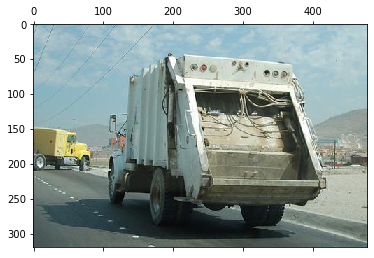

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = np.array(Image.open(img_path))
plt.matshow(img)